<img src="https://www.lsce.ipsl.fr/Css/img/banniere_LSCE_75.png" width="600px">

## Extracting continent shorelines

### Example with various paleo orca 2.3 configurations

- Author: Patrick Brockmann
- Version: 22/04/2023

## ===============================================
## Step 1: 
* Extract mesh

In [ ]:
import numpy as np
import xarray as xr

In [ ]:
#file = "https://thredds-su.ipsl.fr/thredds/dodsC/ipsl_thredds/brocksce/PALEORCA2.3/14Ma/IPSL.PALEORCA2_gridCF.nc"
#file = "https://thredds-su.ipsl.fr/thredds/dodsC/ipsl_thredds/brocksce/PALEORCA2.3/17Ma/IPSL.PALEORCA2_gridCF.nc"
file = "https://thredds-su.ipsl.fr/thredds/dodsC/ipsl_thredds/brocksce/gridsCF/IPSL.ORCA2_gridCF.nc"

ds = xr.open_dataset(file)
ds

In [ ]:
# MASKDRAW or MASK can be used since duplicate polys will be removed later
#mask = xr.where(ds['MASKDRAW'].isel(depth=0) == 1, 1, np.nan)
try: 
    mask = xr.where(ds['MASK'].isel(depth=0) == 1, 1, np.nan)
except:
    mask = xr.where(ds['mask'].isel(depth=0) == 1, 1, np.nan)
mask.plot()

In [ ]:
# build boundaries and and mask them

mask = mask.to_numpy().reshape(-1)
print(mask.shape)

mask1 = mask[~np.isnan(mask)]
#mask1 = mask
print(mask1.shape[0])

blon = ds['bounds_lon'].to_numpy()
blat = ds['bounds_lat'].to_numpy()
nvertex = blon.shape[-1]
print(nvertex)

blon = blon.reshape(-1, nvertex)
blat = blat.reshape(-1, nvertex)
print(blon.shape)

mask = np.repeat(mask, nvertex).reshape(mask.shape[0], nvertex)

blon = blon[~np.isnan(mask)].reshape(mask1.shape[0], nvertex)
blat = blat[~np.isnan(mask)].reshape(mask1.shape[0], nvertex)
print(blon.shape)

In [ ]:
deg2rad = np.pi/180.
R = 6371E3

# Convert to cartesian 3D CS (geocentric)
x = R * np.cos(blat*deg2rad)*np.cos(blon*deg2rad)
y = R * np.cos(blat*deg2rad)*np.sin(blon*deg2rad)
z = R * np.sin(blat*deg2rad)

In [ ]:
# To limit precision (clean with tolerance will do the same thing) 
#x = np.rint(x*1000)/1000
#y = np.rint(y*1000)/1000
#z = np.rint(z*1000)/1000

In [ ]:
# Structures for polydata
points = np.stack((x,y,z), axis=2).reshape(x.size, 3)
faces = np.arange(x.shape[0] * nvertex).reshape(x.shape[0], nvertex)
faces = np.insert(faces, 0, nvertex, axis=1)

In [ ]:
import pyvista as pv
mesh = pv.PolyData(points, faces)
mesh

In [ ]:
# Clean polydata with tolerance set
mesh = pv.PolyData(points, faces)

# R = 6371E3 ==> tolerance = 10       # Geodetic projection
mesh.clean(inplace=True, tolerance=10)     
mesh

In [ ]:
import vtk

In [ ]:
# Duplicate cells removed
removePolyData = vtk.vtkRemoveDuplicatePolys()
removePolyData.SetInputData(mesh)
removePolyData.Update()

mesh = removePolyData.GetOutput()
mesh = pv.wrap(mesh)
mesh

In [ ]:
import pyvista as pv
import vtk

vtk.vtkLogger.SetStderrVerbosity(vtk.vtkLogger.VERBOSITY_OFF)

edges = mesh.extract_feature_edges(boundary_edges=True)

pl = pv.Plotter()
pl.set_background('white')

actor1 = pl.add_mesh(pv.Sphere(radius=R*0.999, theta_resolution=360, phi_resolution=180))
actor2 = pl.add_mesh(mesh, show_edges=True, edge_color="gray")
actor3 = pl.add_mesh(edges, color="red", line_width=2)
viewer = pl.show(jupyter_backend='panel', return_viewer=True)
display(viewer)

In [ ]:
edges.GetNumberOfLines()

In [ ]:
edges.connectivity()

In [ ]:
regions = edges.connectivity()
regCount = len(set(pv.get_array(regions ,name="RegionId")))
regCount

## ===============================================
## Step 2: 
* Extract polygons. Notice that all the different self intersected polygons are separated from their duplicate points into multiple polygons.
* Project them from a cartesian 3D CS (geocentric) to a global latitude/longitude CS

In [ ]:
import pyvista as pv
import vtk
import random
import numpy as np

edges = mesh.extract_feature_edges(boundary_edges=True)

pl = pv.Plotter()

R = 6371E3
pl.add_mesh(pv.Sphere(radius=R*0.999, theta_resolution=360, phi_resolution=180))
pl.add_mesh(mesh, show_edges=True, edge_color="gray")

regions = edges.connectivity()
regCount = len(set(regions.get_array("RegionId")))

connectivityFilter = vtk.vtkPolyDataConnectivityFilter()
stripper = vtk.vtkStripper()

allPolys = []
for r in range(regCount):
    connectivityFilter.SetInputData(edges)
    connectivityFilter.SetExtractionModeToSpecifiedRegions()
    connectivityFilter.InitializeSpecifiedRegionList()
    connectivityFilter.AddSpecifiedRegion(r)
    connectivityFilter.Update()

    stripper.SetInputData(connectivityFilter.GetOutput())
    stripper.SetJoinContiguousSegments(True)
    stripper.Update() 
    
    cleaner = vtk.vtkCleanPolyData()
    cleaner.SetInputData(stripper.GetOutput())
    cleaner.Update()
    
    reg = cleaner.GetOutput()
    print(r, reg.GetNumberOfCells(), reg.GetNumberOfPoints())
    
    #==============================
    polys = []
    for cellIndex in range(reg.GetNumberOfCells()):

        c = reg.GetCell(cellIndex)
        print("  Cell #%d Number of points: %d"  %(cellIndex, c.GetNumberOfPoints()))
    
        d = c.GetPointIds()

        ids = []
        for idIndex in range(d.GetNumberOfIds()):
            ids.append(d.GetId(idIndex))

        unique, count = np.unique(ids, return_counts=True)
        dup = unique[count > 1]
    
        for id in dup[::-1]:
            select = np.where(ids == id)[0]
            polys.append(ids[select[0]:select[1]+1])
            idsIndices = list(range(select[0],select[1]))
            ids = list(np.delete(ids, idsIndices))
        
    print("  ", len(polys))
    for p in polys:
        points = []
        for id in p:
            points.append(reg.GetPoint(id))
        m1 = pv.MultipleLines(points)
        print("  add poly")
        allPolys.append(points)
      
        random_color = "#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
        pl.add_mesh(m1, color=random_color, line_width=4)

viewer = pl.show(jupyter_backend='trame', return_viewer=True)
display(viewer)

In [ ]:
len(allPolys)

In [ ]:
import shapely
from pyproj import Transformer

#=======================================================
# From a cartesian 3D CS (geocentric) to a global latitude/longitude CS
trans_GPS_to_XYZ = Transformer.from_crs(4978, 4326, always_xy=True)

#=======================================================
# Define a function to make continuous the polygon
# because the projection transformation produces output
# between -180 and 180 

def makePolygonContinuous(arrayLonLat):
    for i in range(1,len(arrayLonLat)):
        lon1 = arrayLonLat[i-1][0]
        lon2 = arrayLonLat[i][0]
        if (abs(lon2-360-lon1) < abs(lon2-lon1)):
            arrayLonLat[i][0] = lon2-360
        elif (abs(lon2+360-lon1) < abs(lon2-lon1)):
            arrayLonLat[i][0] = lon2+360
        
    return arrayLonLat

#=======================================================
allPolys2 = []
for polyIndex in range(len(allPolys)):
    #print(polyIndex, len(allPolys[polyIndex]))
    points = []
    for point in allPolys[polyIndex]:              
        x,y,z = point
        lon, lat, Z = trans_GPS_to_XYZ.transform(x,y,z)
        points.append([lon, lat])

    points = makePolygonContinuous(points)
        
    polygonShapely = shapely.Polygon(points)
    polygonShapelyOriented = shapely.geometry.polygon.orient(polygonShapely)
    
    allPolys2.append(polygonShapelyOriented)

## ===============================================
## Step 3: 
* Create paths with holes if present with right orientation

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib
import shapely
import cartopy.crs as ccrs
import random
import pickle

#-----------------------------------------
polygons = allPolys2
    
#-----------------------------------------
def polygon2path(poly):
    path = Path.make_compound_path(
               Path(poly.exterior.coords, closed=True),
               *[Path(ring.coords) for ring in poly.interiors])
    return path
#-----------------------------------------
fig = plt.figure(figsize=(10,5))

map_proj = ccrs.Robinson(10)
#map_proj = ccrs.Orthographic(150, -40) 
#map_proj = ccrs.Orthographic(-10, 60)
ax = fig.add_subplot(1, 1, 1, projection=map_proj)

transform = ccrs.Geodetic()

paths = []
holesNumber = []
for n,polygonA in enumerate(polygons):
    holes = []
    for m,polygonB in enumerate(polygons):
        if (m == n): continue
        if polygonA.contains(polygonB):
            holes.append(polygonB.exterior.coords)
            holesNumber.append(m)
    if n in holesNumber: continue  # n is a hole
    polygonNew = shapely.geometry.Polygon(polygonA.exterior.coords, holes=holes)
    polygonNew = shapely.geometry.polygon.orient(polygonNew)   # Orient to be oriented counter-clockwise
    
    path = polygon2path(polygonNew)
    paths.append(path)

    random_color = "#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
    patch = PathPatch(path, transform=transform, facecolor=random_color, lw=0.5, edgecolor="black")
    ax.add_patch(patch)

ax.set_global()
ax.gridlines()
plt.show()

## ===============================================
## Step 4: 
* Check by reading the paths file

In [ ]:
import os
filePaths = "paths_03.pickle"
print(filePaths)

In [ ]:
import pickle
pickle.dump(paths, open(filePaths,"wb"))

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import matplotlib
import random

fig = plt.figure(figsize=(10,5))

map_proj = ccrs.Robinson(10)
#map_proj = ccrs.Orthographic(-10, -60)

transform = ccrs.Geodetic()

ax = fig.add_subplot(1, 1, 1, projection=map_proj)

with open(filePaths, "rb") as file:
    paths = pickle.load(file)
print(len(paths))

for path in paths:
    random_color = "#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
    patch = matplotlib.patches.PathPatch(path, facecolor=random_color, edgecolor='black', lw=0.5,
                                          transform=transform)
    ax.add_patch(patch)
ax.set_global()
ax.gridlines()

plt.show()

## ===============================================
## Step 5: 
* Interactive plot

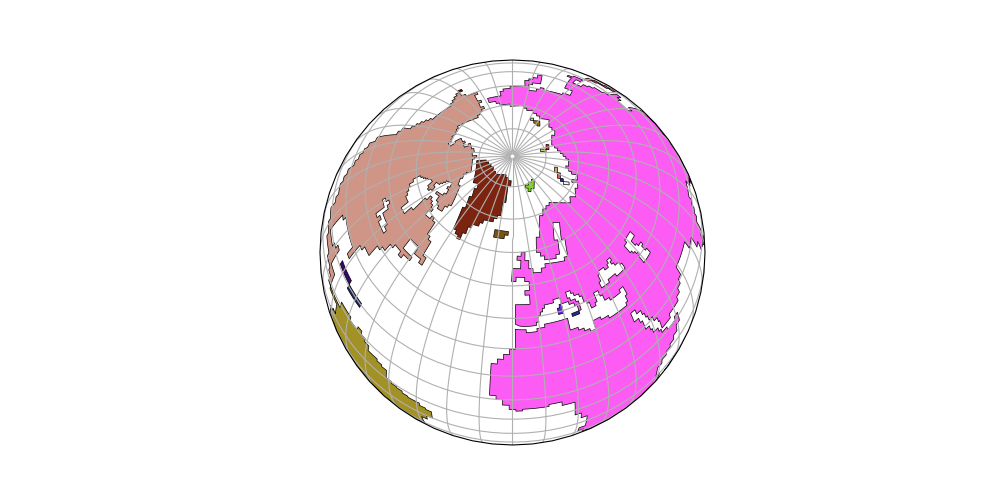

In [5]:
%matplotlib widget

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import matplotlib
import random
import pickle

fig = plt.figure(figsize=(10,5))

proj0 = ccrs.Geodetic()
proj1 = ccrs.Orthographic(-10, 60)

ax = fig.add_subplot(1, 1, 1, projection=proj1)
ax.set_global()

with open("paths_03.pickle", "rb") as file:
    paths = pickle.load(file)

patches = []
colors = []
for path in paths:
    random_color = "#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
    colors.append(random_color)
    patch = matplotlib.patches.PathPatch(path)
    patches.append(patch)

def onpress(event):
    global proj1
    if event.button == 1:
        lon, lat = proj0.transform_point(event.xdata, event.ydata, src_crs=proj1)
        proj1 = ccrs.Orthographic(lon, lat)
        ax = fig.add_subplot(1, 1, 1, projection=proj1)
        p = matplotlib.collections.PatchCollection(patches, facecolor=colors, edgecolor='black', lw=0.5,
                                           transform=proj0)
        ax.add_collection(p)
        ax.set_global()
        ax.gridlines(xlocs=np.arange(-180,180,10), ylocs=np.arange(-80,90,10))
        plt.draw()

fig.canvas.mpl_connect('button_press_event', onpress)

p = matplotlib.collections.PatchCollection(patches, facecolor=colors, edgecolor='black', lw=0.5,
                                           transform=proj0)
ax.add_collection(p)
ax.gridlines(xlocs=np.arange(-180,180,10), ylocs=np.arange(-80,90,10))
plt.show()